In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, GaussianNoise
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1

d = 3  # visible dimension
m = 2  # latent dimension
true_W = np.array([[0, 0, 0],
                  [-1, -1, 1],
                  [1, -1, 1], 
                  [0, -1, 1]])
theta0 = rnd.uniform(-0.1, 0.1, (d+1, m+1))

In [4]:
true_data_dist = RestrictedBoltzmannMachine(true_W)
X = true_data_dist.sample(n)

In [5]:
X_mean = np.mean(X, axis=0)
X_centred = X - X_mean
X_cov = (1/n)*np.dot(X_centred.T, X_centred)

In [6]:
for i in range(d):
    print('empirical prob of x_i is {}.'.format(np.mean(X[:, i])))

empirical prob of x_i is 0.2885.
empirical prob of x_i is 0.7199.
empirical prob of x_i is 0.5009.


In [7]:
model = RestrictedBoltzmannMachine(theta0)

In [8]:
noise = GaussianNoise(mean=np.zeros(d), cov=X_cov)
var_dist = RBMLatentPosterior(theta0)

In [9]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)

         Current function value: 1.297821
         Iterations: 4
         Function evaluations: 98
         Gradient evaluations: 86
         Current function value: 1.363787
         Iterations: 0
         Function evaluations: 110
         Gradient evaluations: 98


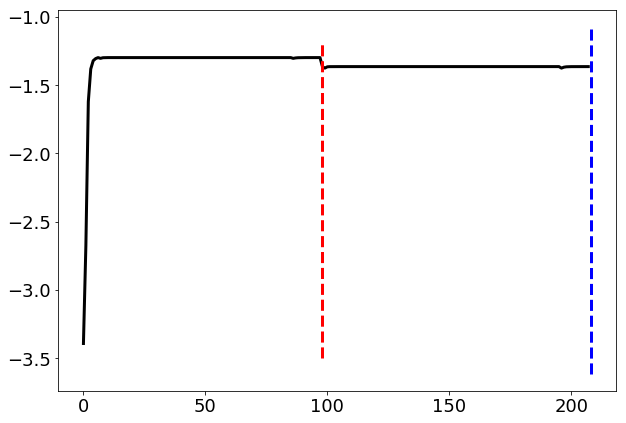

In [10]:
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, theta0=theta0.reshape(-1), stop_threshold=10**-5)

In [12]:
model.theta.reshape(d+1, m+1)

array([[-5.06920603,  0.64515019,  1.7049517 ],
       [ 0.6515064 , -2.46447541,  0.50799756],
       [ 0.8699153 ,  0.48771526, -2.51649115],
       [ 0.30595359,  1.24025029,  0.52208663]])